# Clipping NetCDF files to Polygons

netCDF files are great file formats to store scientific data - especially climate related data. But these files are typically large and our humble systems lose out on memory in processing them. Unfortunately, the python netcdf package also doesn't provide a direct way to clip a large netcdf file to a polygon/extent.

This notebook solves this problem. The following function does three actions:
1. Sub-sets a large netcdf file to geographical bounds of a given polygon.
2. Converts this sub-set netcdf file into a GeoTIFF (Have observed netcdf files not capturing the extent properly after subsetting; converting to GeoTIFF solves this problem)
3. Clip the GeoTIFF to the given polygon. 

In [1]:
import xarray as xr
import rioxarray as rio
from numpy import *
from netCDF4 import Dataset
import fiona
from osgeo import gdal, ogr



def clip_to_polygon(ncfile,variable, polygon, new_file_name):
    '''
    ncfile: Path to the .nc file
    variable: A .nc file can have many variables measured. But we'll present a GeoTIFF of only single variable/band.
    polygon: path to shapefile/geojson that to which the .nc file has to be clipped
    new_file_name: Path and name of the new files created. (Without extensions - we'll add extensions within the code as and when required)
    '''
    #Open and read the .nc file
    data = Dataset(ncfile, mode='r')

    lats = data.variables["lat"][:]
    lons = data.variables["lon"][:]
    tims = data.variables["time"][:]
    
    # Capture geographical bounds of the polygon
    with fiona.open(polygon) as f:
        geom_bounds = f.bounds
    #geom=f[0]['geometry']
    latbound = [geom_bounds[1],geom_bounds[3]]
    lonbound = [geom_bounds[0],geom_bounds[2]]
    
    
    # Making the bounding box for the satellite image - INDEXES
    lat_lb = argmin(abs(lats-latbound[0]))
    lat_ub = argmin(abs(lats-latbound[1]))

    lon_lb = argmin(abs(lons-lonbound[0]))
    lon_ub = argmin(abs(lons-lonbound[1]))
    
    #Reading only values in the bounding box
    lat_sub = lats[lat_ub:lat_lb]
    lon_sub = lons[lon_lb:lon_ub]
    
    # Create a new empty NetCDF Files into which the subset of given netCDF file will be written
    my_file = Dataset(str(new_file_name)+'.nc','w',format='NETCDF4')
    
    # Add dimensions to the empty NDF
    ldim = abs(lat_lb-lat_ub)
    lndim = abs(lon_ub-lon_lb)
    
    lat_dim = my_file.createDimension('lat',ldim)
    lon_dim = my_file.createDimension('lon',lndim)
    time_dim = my_file.createDimension('time',None)
    
    
    #Create variables in the empty NetCDF
    time = my_file.createVariable('time', float32, ('time',))
    time.units=data.variables['time'].units
    time.long_name='time'

    latitudes = my_file.createVariable("lat", 'f4', ('lat',))
    latitudes.units=data.variables['lat'].units

    longitudes = my_file.createVariable("lon", 'f4', ('lon',))
    longitudes.units=data.variables['lon'].units
    
    
    new_nc_variable = my_file.createVariable(str(variable), float32, ('time','lat','lon'))
    
    ## Write data to variables
    latitudes[:] = lat_sub
    longitudes[:] = lon_sub

    for i,val in enumerate(tims):
        time[i] = val
        new_nc_variable[i,:,:] = data.variables[variable][i,lat_ub:lat_lb,lon_lb:lon_ub]
        
    data.close()
    my_file.close()
    
    
    # Convert to the clipped file to GeoTiff and save it.
    sub_ncfile = xr.open_dataset(str(new_file_name)+'.nc')
    var = sub_ncfile[variable]
    var = var.rio.set_spatial_dims('lon','lat')
    var.rio.set_crs("epsg:4326")
    var.rio.to_raster(str(new_file_name)+r".tif")
    
    sub_ncfile.close()
    # Clip to polygon and save it.
    OutTile = gdal.Warp(str(new_file_name)+r"_clipped.tif", 
                    str(new_file_name)+r".tif", 
                    cutlineDSName=polygon,
                    cropToCutline=True,
                    dstNodata = 0)
    OutTile = None 
    return None

Now we will run the above function with following arguments:
1. ncfile: Land cover classification from ERA-5 present in CWD
2. variable: "lccs_class" is the required variable that presents land cover value for different pixel.
3. polygon: We'll clip it to Dehradun.geojson present in CWD
4. new_file_name: We are naming it Dehradun_2020 in the CWD.

In [2]:
import time
start_time = time.time()
clip_to_polygon("C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1.nc","lccs_class","Dehradun.geojson",'Dehradun_2020')
print("Time taken to run the function: %s seconds" % (time.time() - start_time))

Time taken to run the function: 0.984039306640625 seconds


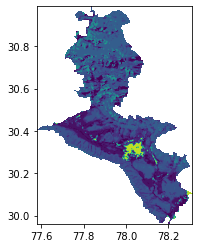

<AxesSubplot:>

In [5]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

#Plotting the clipped tif file
imagery = rasterio.open("Dehradun_2020_clipped.tif")
show(imagery)

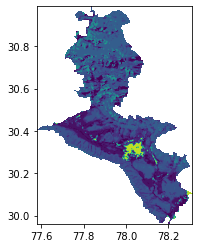

<AxesSubplot:>